In [92]:
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import plotly.express as px
import matplotlib.pyplot as plt
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show, curdoc
from bokeh.models import ColumnDataSource, Select, CheckboxButtonGroup, Div, MultiChoice, CDSView, GroupFilter
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import Viridis256
from bokeh.models import LogColorMapper
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment import data as unemployment
from bokeh.sampledata.us_counties import data as counties
from bokeh.layouts import row, column, gridplot

Combined DataFrame head:
                Description Transaction Date Transaction Time Tax Type  \
0  GPA.3345-8622-1982-51549      Jun 1, 2021  12:15:21 PM PDT      NaN   
1  GPA.3345-8622-1982-51549      Jun 1, 2021  12:15:21 PM PDT      NaN   
2  GPA.3309-9945-4854-73987      Jun 1, 2021  12:15:56 PM PDT      NaN   
3  GPA.3309-9945-4854-73987      Jun 1, 2021  12:15:56 PM PDT      NaN   
4  GPA.3370-7096-7934-01916      Jun 1, 2021   5:38:09 PM PDT      NaN   

  Transaction Type Refund Type  \
0           Charge         NaN   
1       Google fee         NaN   
2           Charge         NaN   
3       Google fee         NaN   
4           Charge         NaN   

                                       Product Title  \
0  Pathfinder DM tools (Complete Reference for Pa...   
1  Pathfinder DM tools (Complete Reference for Pa...   
2  Character Manager (Complete Reference for Path...   
3  Character Manager (Complete Reference for Path...   
4   Character Manager (Complete Reference for

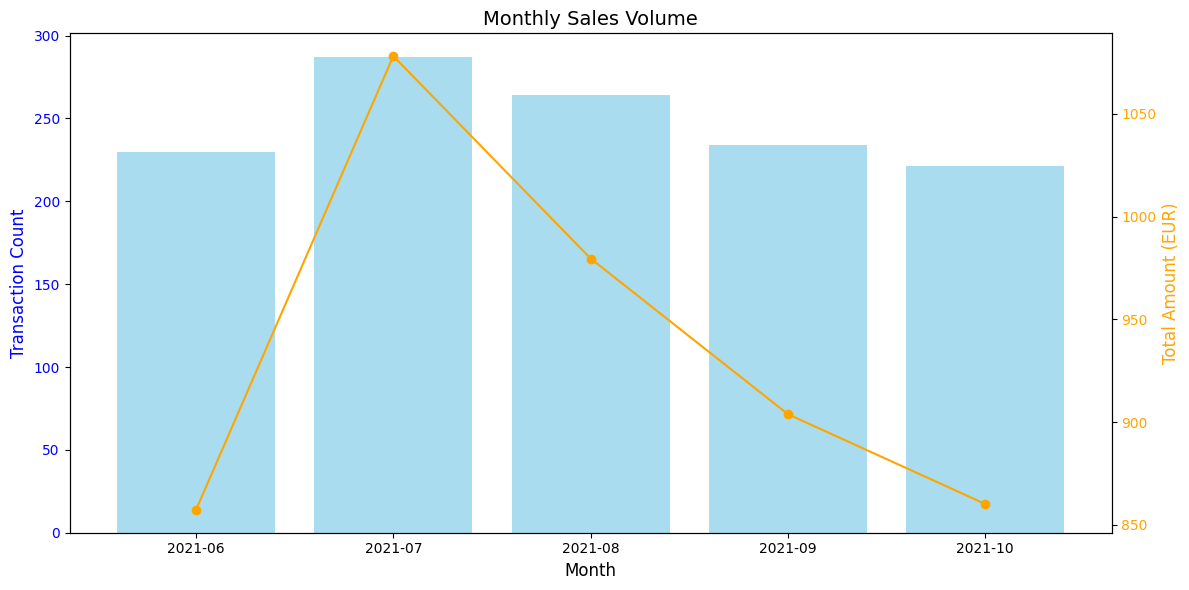

In [44]:
### 1. Sales volume
file_paths = glob.glob(os.path.join('Data', 'sales_*.csv'))
sales_dfs = [pd.read_csv(file) for file in file_paths]
sales_df = pd.concat(sales_dfs, ignore_index=True)
print("Combined DataFrame head:")
print(sales_df.head())
print("Number of rows:", sales_df.shape[0])
sales_df = sales_df[(sales_df['Transaction Type'] == 'Charge') &
                    (sales_df['Product id'] == 'com.vansteinengroentjes.apps.ddfive')]
print(sales_df.head())

sales_df['Transaction Date'] = pd.to_datetime(sales_df['Transaction Date'])


sales_df['Month'] = sales_df['Transaction Date'].dt.to_period('M')


monthly_sales = sales_df.groupby('Month').agg(
    transaction_count=('Transaction Date', 'count'),
    total_amount=('Amount (Merchant Currency)', 'sum')
).reset_index()

print(monthly_sales)
fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.bar(monthly_sales['Month'].astype(str), monthly_sales['transaction_count'], color='skyblue', label='Transaction Count', alpha=0.7)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Transaction Count', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(monthly_sales['Month'].astype(str), monthly_sales['total_amount'], color='orange', marker='o', label='Total Amount (EUR)')
ax2.set_ylabel('Total Amount (EUR)', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')


plt.title('Monthly Sales Volume', fontsize=14)
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()


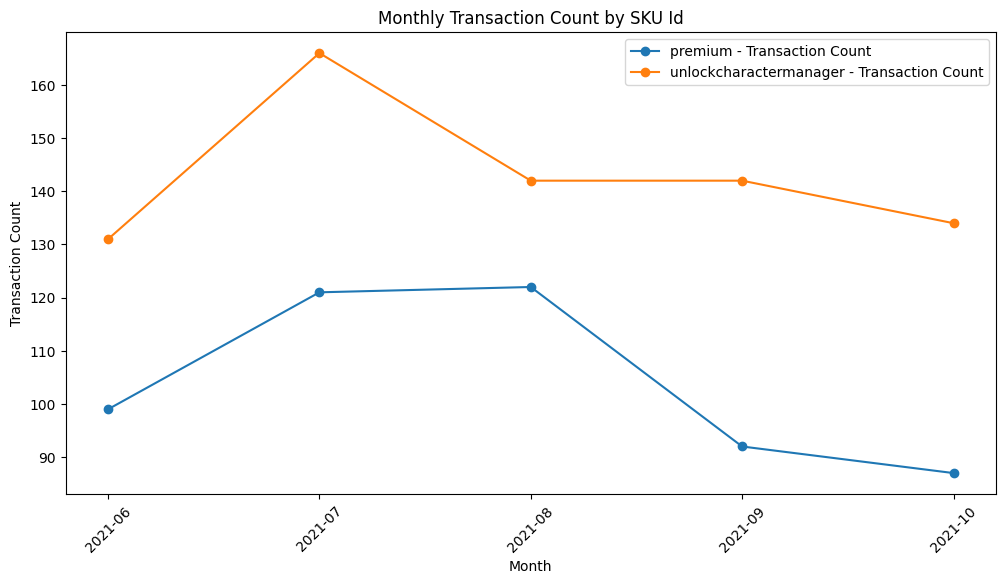

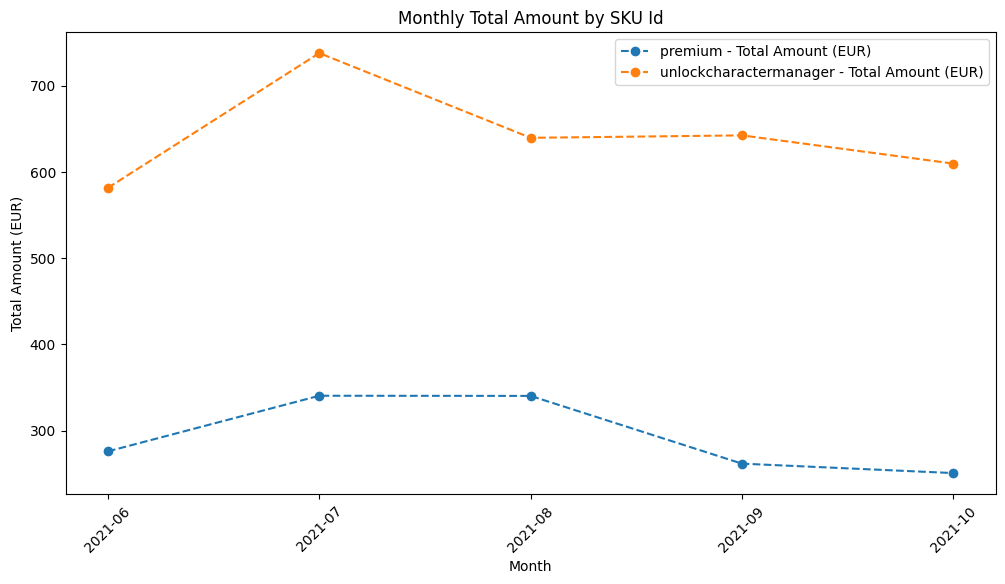

In [36]:
### 2. Attribute Segmentation and Filtering
sales_df['Transaction Date'] = pd.to_datetime(sales_df['Transaction Date'])


sales_df['Month'] = sales_df['Transaction Date'].dt.to_period('M')


sku_sales = sales_df.groupby(['Sku Id', 'Month']).agg(
    transaction_count=('Transaction Date', 'count'),
    total_amount=('Amount (Merchant Currency)', 'sum')
).reset_index()

sku_ids = sku_sales['Sku Id'].unique()

plt.figure(figsize=(12, 6))
for sku in sku_ids:
    sku_data = sku_sales[sku_sales['Sku Id'] == sku]
    plt.plot(sku_data['Month'].astype(str), sku_data['transaction_count'], marker='o', label=f'{sku} - Transaction Count')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.title('Monthly Transaction Count by SKU Id')
plt.legend()
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
for sku in sku_ids:
    sku_data = sku_sales[sku_sales['Sku Id'] == sku]
    plt.plot(sku_data['Month'].astype(str), sku_data['total_amount'], marker='o', linestyle='--', label=f'{sku} - Total Amount (EUR)')
plt.xlabel('Month')
plt.ylabel('Total Amount (EUR)')
plt.title('Monthly Total Amount by SKU Id')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [37]:
### crashes
file_paths = glob.glob(os.path.join('Data', 'stats_crashes_*.csv'))
stats_crashes_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_crashes_dfs = pd.concat(stats_crashes_dfs, ignore_index=True)
print("Combined DataFrame head:")
stats_crashes_dfs

Combined DataFrame head:


,Date,Package Name,Daily Crashes,Daily ANRs
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,15,1
1,2021-06-02,com.vansteinengroentjes.apps.ddfive,12,1
2,2021-06-03,com.vansteinengroentjes.apps.ddfive,20,1
3,2021-06-04,com.vansteinengroentjes.apps.ddfive,13,0
4,2021-06-05,com.vansteinengroentjes.apps.ddfive,14,0
...,...,...,...,...
209,2021-12-27,com.vansteinengroentjes.apps.ddfive,64,0
210,2021-12-28,com.vansteinengroentjes.apps.ddfive,60,0
211,2021-12-29,com.vansteinengroentjes.apps.ddfive,37,0
212,2021-12-30,com.vansteinengroentjes.apps.ddfive,46,1


In [38]:
### stats_ratings_country
file_paths = glob.glob(os.path.join('Data', 'stats_ratings_*_country.csv'))
stats_ratings_country_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_ratings_country_dfs = pd.concat(stats_ratings_country_dfs, ignore_index=True)
print("Combined DataFrame head:")
stats_ratings_country_dfs

Combined DataFrame head:


,Date,Package Name,Country,Daily Average Rating,Total Average Rating
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,AR,NaN,4.20
1,2021-06-01,com.vansteinengroentjes.apps.ddfive,AT,NaN,3.91
2,2021-06-01,com.vansteinengroentjes.apps.ddfive,AU,NaN,4.19
3,2021-06-01,com.vansteinengroentjes.apps.ddfive,BA,NaN,5.00
4,2021-06-01,com.vansteinengroentjes.apps.ddfive,BD,NaN,5.00
...,...,...,...,...,...
18612,2021-12-31,com.vansteinengroentjes.apps.ddfive,US,NaN,4.04
18613,2021-12-31,com.vansteinengroentjes.apps.ddfive,UY,NaN,4.86
18614,2021-12-31,com.vansteinengroentjes.apps.ddfive,VE,NaN,4.00
18615,2021-12-31,com.vansteinengroentjes.apps.ddfive,VN,NaN,5.00


In [39]:
### stats_rating_overview
file_paths = glob.glob(os.path.join('Data', 'stats_ratings_*_overview.csv'))
stats_ratings_overview_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_ratings_overview_dfs = pd.concat(stats_ratings_overview_dfs, ignore_index=True)
print("Combined DataFrame head:")
stats_ratings_overview_dfs

Combined DataFrame head:


,Date,Package Name,Daily Average Rating,Total Average Rating
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,5.0,4.15
1,2021-06-02,com.vansteinengroentjes.apps.ddfive,2.0,4.15
2,2021-06-03,com.vansteinengroentjes.apps.ddfive,NaN,4.15
3,2021-06-04,com.vansteinengroentjes.apps.ddfive,NaN,4.15
4,2021-06-05,com.vansteinengroentjes.apps.ddfive,NaN,4.15
...,...,...,...,...
209,2021-12-27,com.vansteinengroentjes.apps.ddfive,NaN,4.14
210,2021-12-28,com.vansteinengroentjes.apps.ddfive,4.0,4.14
211,2021-12-29,com.vansteinengroentjes.apps.ddfive,NaN,4.14
212,2021-12-30,com.vansteinengroentjes.apps.ddfive,NaN,4.14


In [40]:
### reviews 
file_paths = glob.glob(os.path.join('Data', 'reviews_*.csv'))
reviews_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
reviews_dfs = pd.concat(reviews_dfs, ignore_index=True)
print("Combined DataFrame head:")
reviews_dfs

Combined DataFrame head:


,Package Name,App Version Code,App Version Name,Reviewer Language,Device,Review Submit Date and Time,Review Submit Millis Since Epoch,Review Last Update Date and Time,Review Last Update Millis Since Epoch,Star Rating,Review Title,Review Text,Developer Reply Date and Time,Developer Reply Millis Since Epoch,Developer Reply Text,Review Link
0,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,flox,2021-06-01T10:28:24Z,1622543304307,2021-06-01T10:28:24Z,1622543304307,5,NaN,NaN,NaN,NaN,NaN,NaN
1,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,river,2021-06-02T16:16:24Z,1622650584378,2021-06-02T16:16:24Z,1622650584378,2,NaN,"No monster descriptions, just stats. If there ...",2021-06-02T16:40:58Z,1.622652e+12,Unlocking either the dm tools or the character...,http://play.google.com/console/developers/6648...
2,com.vansteinengroentjes.apps.ddfive,NaN,NaN,en,U693CL,2021-06-08T06:01:48Z,1623132108319,2021-06-08T06:01:48Z,1623132108319,5,NaN,Wizard,NaN,NaN,NaN,http://play.google.com/console/developers/6648...
3,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,taimen,2020-04-20T19:31:03Z,1587411063002,2021-06-08T22:44:27Z,1623192267754,5,NaN,It helps you find what you need for DND 5e,NaN,NaN,NaN,http://play.google.com/console/developers/6648...
4,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,de,OnePlus7TPro,2021-06-12T11:20:20Z,1623496820823,2021-06-12T11:21:34Z,1623496894692,3,NaN,Would be very useful if it wasn't so buggy. Cu...,NaN,NaN,NaN,http://play.google.com/console/developers/6648...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,com.vansteinengroentjes.apps.ddfive,NaN,NaN,fr,klein,2021-12-11T07:13:14Z,1639206794948,2021-12-11T07:13:14Z,1639206794948,1,NaN,NaN,NaN,NaN,NaN,NaN
74,com.vansteinengroentjes.apps.ddfive,NaN,NaN,en,troika_sprout,2021-12-13T18:54:40Z,1639421680663,2021-12-13T18:54:40Z,1639421680663,5,NaN,NaN,NaN,NaN,NaN,NaN
75,com.vansteinengroentjes.apps.ddfive,288.0,8.1.1,en,beyond1q,2021-12-13T22:56:04Z,1639436164880,2021-12-13T22:56:04Z,1639436164880,4,NaN,NaN,NaN,NaN,NaN,NaN
76,com.vansteinengroentjes.apps.ddfive,289.0,8.1.2,en,berlna,2021-12-28T14:19:58Z,1640701198042,2021-12-28T14:19:58Z,1640701198042,4,NaN,This app is amazing! There is a lot of content...,NaN,NaN,NaN,http://play.google.com/console/developers/6648...


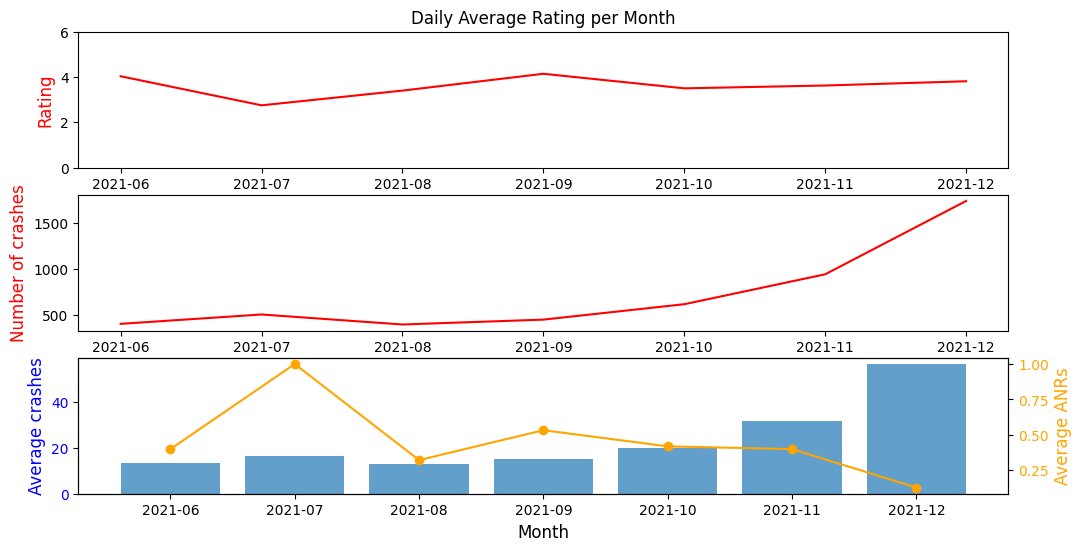

In [41]:
### 3. Ratings vs Stability
### user satisfaction
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(12, 6))

stats_ratings_country_dfs['Date'] = pd.to_datetime(stats_ratings_country_dfs['Date'])
stats_ratings_country_dfs['Month'] = stats_ratings_country_dfs['Date'].dt.to_period('M')
stats_ratings_country_dfs['Day of The Week'] = stats_ratings_country_dfs['Date'].dt.dayofweek
stats_ratings_country_dfs.describe()

group_ratings_by_month = stats_ratings_country_dfs.groupby(['Month']).agg(
    daily_avg_per_country = ('Daily Average Rating', 'mean'),
).reset_index()
group_ratings_by_month['Daily Average Rating per Month'] = group_ratings_by_month['daily_avg_per_country']

ax1.set(ylim=(0.0, 6.0))
ax1.plot(group_ratings_by_month['Month'].astype(str), group_ratings_by_month['daily_avg_per_country'], color='red')
ax1.title.set_text('Daily Average Rating per Month')
ax1.set_ylabel('Rating', color='red', fontsize=12)
ax1.set_xlabel('Month', color='red', fontsize=12)

stats_crashes_dfs['Date'] = pd.to_datetime(stats_crashes_dfs['Date'])
stats_crashes_dfs['Month'] = stats_crashes_dfs['Date'].dt.to_period('M')
stats_crashes_dfs['Day of The Week'] = stats_crashes_dfs['Date'].dt.dayofweek
group_crashes_by_month = stats_crashes_dfs.groupby(['Month']).agg(
    daily_avg_crashes = ('Daily Crashes', 'mean'),
    nr_crashes_per_month = ('Daily Crashes', 'sum'),
    daily_avg_anr = ('Daily ANRs', 'mean')
).reset_index()
group_crashes_by_month['Daily Average Rating'] = group_ratings_by_month['Daily Average Rating per Month']

ax2.plot(group_crashes_by_month['Month'].astype(str),group_crashes_by_month['nr_crashes_per_month'], color='red')
ax2.set_ylabel('Number of crashes', color='red', fontsize=12)
### stability -> average nr of crashes and anr / month
ax3.bar(group_crashes_by_month['Month'].astype(str), group_crashes_by_month['daily_avg_crashes'], label='Avg rating / Month', alpha=0.7)
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Average crashes', color='blue', fontsize=12)
ax3.tick_params(axis='y', labelcolor='blue')

axf = ax3.twinx()
axf.plot(group_crashes_by_month['Month'].astype(str), group_crashes_by_month['daily_avg_anr'], color='orange', marker='o')
axf.set_ylabel('Average ANRs', color='orange', fontsize=12)
axf.tick_params(axis='y', labelcolor='orange')

     index       featurecla  scalerank  LABELRANK  \
0        0  Admin-0 country          1          6   
1        1  Admin-0 country          1          3   
2        2  Admin-0 country          1          7   
3        3  Admin-0 country          1          2   
4        4  Admin-0 country          1          2   
..     ...              ...        ...        ...   
172    172  Admin-0 country          1          5   
173    173  Admin-0 country          1          6   
174    174  Admin-0 country          1          6   
175    175  Admin-0 country          1          5   
176    176  Admin-0 country          1          3   

                      SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL               TYPE  \
0                           Fiji    FJI         0      2  Sovereign country   
1    United Republic of Tanzania    TZA         0      2  Sovereign country   
2                 Western Sahara    SAH         0      2      Indeterminate   
3                         Canada    CAN        

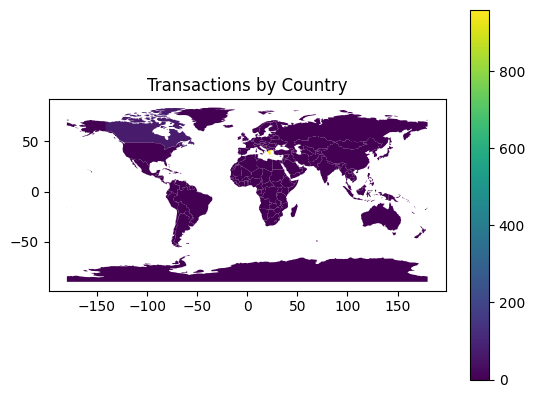

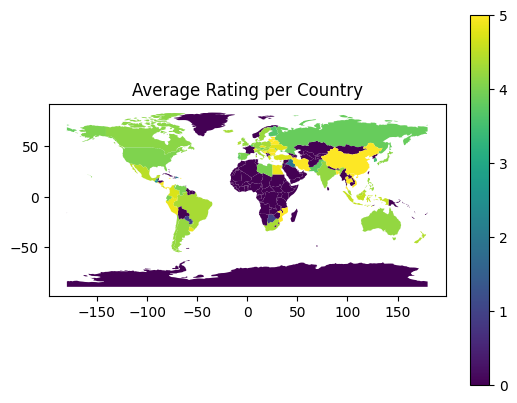

In [109]:
### 4. Geographical development
group_ratings_by_country = stats_ratings_country_dfs.groupby(['Country']).agg(
    daily_avg_per_country = ('Total Average Rating', 'mean')).reset_index()

group_transactions_by_country = sales_df.groupby(['Buyer Country']).agg(
    transaction_count=('Transaction Date', 'count')
).reset_index()

d = {'ISO_A2': group_ratings_by_country['Country'], 'AVG_Rating': group_ratings_by_country['daily_avg_per_country'], 'Transactions':group_transactions_by_country['transaction_count']}
new_frame_ratings_transactions = pd.DataFrame(data=d)
new_frame_ratings_transactions = new_frame_ratings_transactions.fillna(0)

# world map data, so we can merge on the ISO_A2 code of the country
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
gdf = gpd.read_file(url)
# merge and fill the counts for the rest of the countries with 0 
world = gdf.merge(new_frame_ratings_transactions, how="left", left_on="ISO_A2", right_on="ISO_A2").reset_index()
world['Transactions'] = world['Transactions'].fillna(0)
world['AVG_Rating'] = world['AVG_Rating'].fillna(0)
print(world)
# Plotting
world.plot(column='Transactions', legend=True)
plt.title("Transactions by Country")
world.plot(column='AVG_Rating', legend=True)
plt.title("Average Rating per Country")
plt.show()

In [113]:
### Dashboard creation
output_file('Dashboard.html', title='Dashboard for Emerald-IT')
### Sales volume
sales_volume_fig = figure(title = 'Sales Volume', x_range = monthly_sales['Month'].astype(str),
             title_location='right',
             toolbar_location='below',
             tools='save')

sales_volume_fig.vbar(x = monthly_sales['Month'].astype(str), top=monthly_sales['transaction_count'], width=0.8, color='blue', legend_label='Transactions')
sales_volume_fig.line(x = monthly_sales['Month'].astype(str), y = monthly_sales['total_amount'], color='red', line_width=3, legend_label='Amount (EUR)')
sales_volume_fig.legend.location = 'top_left'

### Attribute segmentation
attribute_segmentation_fig1 = figure(title = 'Attribute Segmentation', x_range = monthly_sales['Month'].astype(str),
                                    title_location='right',
                                    toolbar_location='below',
                                    tools='save')
attribute_segmentation_fig2 = figure(title = 'Attribute Segmentation', x_range = monthly_sales['Month'].astype(str),
                                    title_location='right',
                                    toolbar_location='below',
                                    tools='save')
premium_data = sku_sales[sku_sales['Sku Id'] == 'premium']
other_data = sku_sales[sku_sales['Sku Id'] != 'premium']
attribute_segmentation_fig1.line(x=premium_data['Month'].astype(str), y=premium_data['transaction_count'], color='blue', legend_label='Transactions - premium')
attribute_segmentation_fig1.line(x=other_data['Month'].astype(str), y=other_data['transaction_count'], color='orange', legend_label='Transactions - unlockcharactermanager')
attribute_segmentation_fig1.legend.location = 'top_right'

attribute_segmentation_fig2.line(x=premium_data['Month'].astype(str), y=premium_data['total_amount'], color='blue', legend_label='Amount - premium')
attribute_segmentation_fig2.line(x=other_data['Month'].astype(str), y=other_data['total_amount'], color='orange', legend_label='Amount - unlockcharactermanager')
attribute_segmentation_fig2.legend.location = 'top_right'

### ratings vs stability

### geographical development
geo_source = GeoJSONDataSource(geojson=world.to_json())
rating_mapper = LinearColorMapper(palette=Viridis256, low=0, high=5)
transaction_mapper = LinearColorMapper(palette=Viridis256, low=0, high=world['Transactions'].max())
world_fig = figure(title='World Chart Transactions', tooltips=[('Country', '@ISO_A2'), ('Transactions', '@Transactions'), ('Average Rating', '@AVG_Rating')], x_range=(-180, 180), y_range=(-90, 90))
world_fig.patches('xs', 'ys', fill_alpha=0.4, fill_color='grey', 
          line_color='black', line_width=0.5, source=geo_source)

color_bar = ColorBar(color_mapper = transaction_mapper, location=(0, 0), title="Transactions")
world_fig.add_layout(color_bar, 'right')
show(row(column(sales_volume_fig, row(attribute_segmentation_fig1, attribute_segmentation_fig2)), world_fig))